# 1. Introduction

This notebook describes my attempt to forecast the sales using prophet. Although, it might not be the most suitable approach for the given problem, I thought it would be interesting to give it a go and share some thoughts. The process was inspired by the top down method proposed by Rob Hyndman for hierarchical forecasting (see chapter 10 of this book for more details: https://otexts.com/fpp2/top-down.html).

Below are the main steps of the process:
- aggregation and forecast at store level - 54 Time Series (one per store) using prophet
- calculate the proportion of each family for each store and forecast that proportion
- finally calculate the forecast at store-family level using the forecast at store level and the forecasted proportions

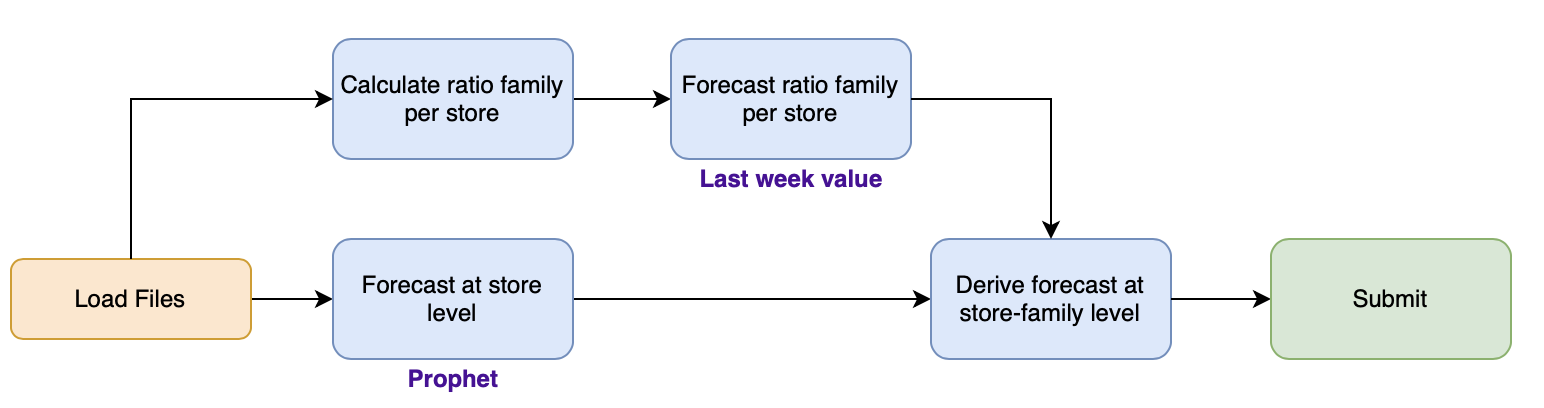


# 2. Loading data and libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from datetime import datetime, timedelta
from tqdm import tqdm

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

import os

data_di = {}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        name = path.split('/')[-1].split('.')[0]
        try:
            data_di[name] = pd.read_csv(path, parse_dates=['date'])
        except:
            data_di[name] = pd.read_csv(path)
        
        # Rename columns to prophet standards
        if 'sales' in data_di[name].columns:
            data_di[name] = data_di[name].rename(columns={'sales': 'y'})
        if 'date' in data_di[name].columns:
            data_di[name] = data_di[name].rename(columns={'date': 'ds'})

# 3. Utils
Note that the Facebook Prophet package does not have any verbose parameters to remove the warning messages easily. As an alternative, I decided to use the function below: <b>suppress_stdout_stderr()</b> <br>
source: https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions

In [ ]:
class suppress_stdout_stderr(object):
    '''
   A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])
        
def rmsle(y_hat, y):
    """Compute Root Mean Squared Logarithmic Error"""
    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y))))**2)/len(y))
                
    return round(metric, 4)

# 4. Quick data exploration
Note that very minimal EDA was made as I primarly wanted to focus on the forecasting method. Note that one condition needs to be respected in order to apply the top down method. Every pair store family to forecast needs to be available in the training set. So let's check that.

In [ ]:
data_di['train'].head(5)

In [ ]:
data_di['test'].head(5)

In [ ]:
print("Number of Time Series (train):")
unique_keys_train = set(zip(data_di['train'].store_nbr, data_di['train'].family))
print(len(unique_keys_train))

print("Number of Time Series (test):")
unique_keys_test = set(zip(data_di['test'].store_nbr, data_di['test'].family))
print(len(unique_keys_test))

print("Keys in the test set that are not in the train set:")
unique_keys_test - unique_keys_train

Great! It looks like we are ok!

### Check missing dates
Prophet is able to deal with missing dates but it is better to check if there are any anyway.

In [ ]:
missing_ds_df = data_di['train'].groupby(['store_nbr', 'family']).resample('D', on='ds')['y'] \
        .first().loc[lambda x: x.isna()].index.to_frame(index=False)

missing_ds_df

In [ ]:
missing_ds_df.ds.unique()

It looks like the Chritmas days have been removed although it shouldn't affect the process too much.

### Plotting a few Time Series
Let's just plot a few Time Series to get a feeling of what we are trying to forecast.

In [ ]:
def plot_ts(key):
    fig, ax = plt.subplots(figsize=(20, 5))
    ts = data_di['train'][(data_di['train'].store_nbr == key[0]) & (data_di['train'].family == key[1])]
    plt.plot(ts.ds, ts.onpromotion*np.median(ts.y), label='promotion')
    plt.plot(ts.ds, ts.y, label='y')
    plt.title("Store: " + str(key[0]) + ", Family: " + key[1])
    plt.legend()
    ax.set_xticks(np.array(ts.ds)[::100])
    ax.tick_params(axis='x',rotation=45)
    plt.show()

In [ ]:
key = random.choice(list(unique_keys_test))
plot_ts(key)

In [ ]:
key = random.choice(list(unique_keys_test))
plot_ts(key)

# 5. Baseline model - Last Year Value
Always good to have a benchmark. Let's first build a quick baseline model using the last year value and let's perform a cross-validation on the last two weeks of the training set.


In [ ]:
train_df, test_df = data_di['train'], data_di['test']

train_df = train_df.assign(last_year_ds = train_df.ds - timedelta(days=52*7))
train_df = pd.merge(train_df, 
                         train_df[['ds', 'store_nbr', 'family', 'y']], 
                         left_on=['last_year_ds', 'store_nbr', 'family'], 
                         right_on=['ds', 'store_nbr', 'family']).rename(columns={'ds_x': 'ds', 'y_x': 'y', 'y_y': 'yhat'})

# Cross validation
val_df = train_df[(train_df.ds >= '2017-08-01') & (train_df.ds <= '2017-08-15')]
print('RMSLE: %s' %rmsle(val_df.yhat, val_df.y))

Let's submit!

In [ ]:
test_df = test_df.assign(last_year_ds = test_df.ds - timedelta(days=52*7))
submission_df = pd.merge(test_df, 
                         train_df[['ds', 'store_nbr', 'family', 'y']], 
                         left_on=['last_year_ds', 'store_nbr', 'family'], 
                         right_on=['ds', 'store_nbr', 'family'])[['id', 'y']]

submission_df.to_csv('submission.csv', index=False)

We get a score on the Leaderboard of: 1.14346
For some reasons, this is higher than our cross-validation result (0.9495).

# 6. Top down approach with Prophet
## Forecasting at store level
Let's plot the sales per store.

In [ ]:
def plot_multi_ts(df, feature, n_cols=6, run_forecast=False, ds_range=None, periods=None, days_to_plot=None):
    
    group_by_store_df = df.groupby(['ds'] + [feature]).agg({'y': 'sum'}).reset_index()
    stores = list(set(group_by_store_df[feature]))
    n_rows = int(len(stores)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 40))
    
    k = 0
    forecasts = []
    for i in tqdm(range(n_rows)):
        for j in range(n_cols):
            ts = group_by_store_df[group_by_store_df[feature] == stores[k]]
            
            if run_forecast:
                df = ts[['ds', 'y']]
                df = df[(df.ds >= ds_range[0]) & (df.ds <= ds_range[1])]
        
                with suppress_stdout_stderr():
                    m = Prophet()
                    m.fit(df)
                    future = m.make_future_dataframe(periods=periods)
                    forecast = m.predict(future)
                
                kwargs = {feature: lambda x: stores[k]}
                forecast = forecast.assign(**kwargs).rename(columns={'yhat': 'yhat_'  + feature})
                forecasts.append(forecast)
                ax[i][j].plot(ts[-days_to_plot:].ds, ts[-days_to_plot:].y)
                ax[i][j].plot(forecast[-periods:].ds, forecast[-periods:][['yhat_'  + feature]])
            else:
                ax[i][j].plot(ts.ds, ts.y)
            
            ax[i][j].set_title(feature + ": " + str(stores[k]), size=16)
            k += 1
    
    if run_forecast:
        forecast_per_feature = pd.concat(forecasts, axis=0)
        forecast_per_feature = pd.merge(group_by_store_df.rename(columns={'y': 'y_' + feature}), forecast_per_feature[['ds', 'yhat_' + feature] + [feature]], on=['ds'] + [feature], how='left')
    
        return forecast_per_feature

In [ ]:
plot_multi_ts(data_di['train'], 'store_nbr', run_forecast=False)

A few remarks:
- an upward trend is noticeable for most stores 
- some stores have sales since only recently which might affect the forecast (e.g. 42, 52...)

Let's now forecast the sales for each store using prophet. Cross-validation will be performed from 2017-08-01 to 2017-08-15.

In [ ]:
# Training period
ds_range = ['2013-01-01', '2017-07-31']
periods = 15
days_to_plot = 100

forecast_per_store = plot_multi_ts(data_di['train'], 'store_nbr', run_forecast=True, ds_range=ds_range, periods=periods, days_to_plot=days_to_plot)

Decent forecasts if we make a visual judgment, although some of the stores don't look quite right (e.g 42, 52...). It might due to the fact that the model is trying to fit from 2013 even though there is no data for those stores.

## Forecast family proportions for each store
Let's now plot the family proportion per store and see how that behaves.

In [ ]:
df = data_di['train']
df = pd.merge(df, forecast_per_store, on=['ds', 'store_nbr'], how='left')
df = df.assign(prop_family_per_store= df.y/df.y_store_nbr).fillna(0)

group_by_store_df = df.groupby(['ds'] + ['store_nbr']).agg({'y': 'sum'}).reset_index()
stores = list(set(group_by_store_df.store_nbr))
n_cols = 6
n_rows = int(len(stores)/n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 40))

k = 0
for i in range(n_rows):
    for j in range(n_cols):
        sub_df = df[df.store_nbr == stores[k]]
        sub_df = sub_df[sub_df.ds >= '2017-05-01']
        for f in df.family.unique():
            ts = sub_df[sub_df.family == f]
            ax[i][j].plot(ts.ds, ts.prop_family_per_store)
            ax[i][j].set_title("Store_nbr: " + str(stores[k]), size=16)
        k += 1

The proportions are quite stable over time, therefore we'll use the last week of available data to calculate proportions over that week and repeat that weekly pattern to forecast the future proportions. It's a big assumption but acceptable for what we are trying to do.

In [ ]:
def get_last_available_week(df):
    # Get date of the last available week
    df = df.assign(diff_from_max_train_ds=df.ds - datetime.strptime(ds_range[1], "%Y-%m-%d"))
    df = df.assign(nb_weeks=np.ceil(df.diff_from_max_train_ds.dt.days/7).astype('int'))
    df = df.assign(last_week_ds=df.ds - (df.nb_weeks*7).map(lambda x: timedelta(x)))
    
    return df

def get_yhat(df):
    df = pd.merge(df, 
    df[['ds', 'store_nbr', 'family', 'prop_family_per_store']].rename(columns={'prop_family_per_store': 'last_week_prop_family_per_store'}),
         left_on = ['last_week_ds', 'store_nbr', 'family'],
         right_on=['ds', 'store_nbr', 'family'],
         how='left'
        ).drop(['diff_from_max_train_ds', 'nb_weeks', 'last_week_ds', 'ds_y'], axis=1).rename(columns={'ds_x': 'ds'})

    df = df.assign(yhat=df.yhat_store_nbr * df.last_week_prop_family_per_store)
    
    return df

df = get_last_available_week(df)
df.head(2)

We can now plug the dates of above to retrieve the family ratios per store and finally derive the forecast at store-family level.

In [ ]:
df = get_yhat(df)
df.head(2)

In [ ]:
print('RMSLE: %s' %rmsle(df[(df.ds > ds_range[1])].yhat, df[(df.ds > ds_range[1])].y))

The metric shows a significant improvement compare to the baseline model.

# 7. Submission

The process is repeated removing the cross-validation period this time for the submission.

In [ ]:
# Training period
ds_range = ['2013-01-01', str(data_di['train'].iloc[-1].ds)[:10]]
periods = len(data_di['test'].ds.unique())
days_to_plot = 100

bind_df = pd.concat([data_di['train'], data_di['test']], axis=0)

forecast_per_store = plot_multi_ts(bind_df, 'store_nbr', run_forecast=True, ds_range=ds_range, periods=periods, days_to_plot=days_to_plot)

In [ ]:
df = pd.concat([data_di['train'], data_di['test']], axis=0)

df = pd.merge(df, forecast_per_store, on=['ds', 'store_nbr'], how='left')
df = df.assign(prop_family_per_store= df.y/df.y_store_nbr)
df.prop_family_per_store = df.prop_family_per_store.fillna(0)

df = get_last_available_week(df)
df = get_yhat(df)

We can plot a few Time Series to see how it looks like.

In [ ]:
plot_ds_range = ['2017-01-01', df.ds.iloc[-1]]
fig, ax = plt.subplots(figsize=(20, 5))
key = random.choice(list(unique_keys_test))
ts = df[(df.store_nbr == key[0]) & (df.family == key[1])]
ts = ts[(ts.ds >= plot_ds_range[0]) & (ts.ds <= plot_ds_range[1])]
plt.plot(ts.ds, ts.onpromotion*np.median(ts.y), label='promotion')
plt.plot(ts.ds, ts.yhat, label='yhat')
plt.plot(ts.ds, ts.y, label='y')
plt.title("Store: " + str(key[0]) + ", Family: " + key[1])
plt.legend()
ax.set_xticks(np.array(ts.ds)[::100])
ax.tick_params(axis='x',rotation=45)
plt.show()

Finally, let's submit!

In [ ]:
df.iloc[data_di['train'].shape[0]:][['id', 'yhat']].rename(columns={'yhat': 'sales'}).to_csv('submission.csv', index=False)

# 8. Conclusion

We managed to forecast sales using a top down approach and prophet. This provides a score of <b>0.52875</b> on the leaderboard. The method is interesting but can't outperform other techniques such as tree models or neural networks. It is also not very scalable. The running time of this notebook is already pretty long and would become even worse if we start adding more features although PandasUdf using spark could be a solution. Adding exogenous variables might be difficult unlike with other ML techniques although it might be possible using the add_regressor() function from Prophet. A similar remark can be made about holidays. It would be interesting to see if we get better performances, feel free to give it a go. Thanks for reading!